In [1]:
import torch
from torch.utils import data
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [2]:
trainset = datasets.MNIST(
    root = "./data/",
    train= True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()]))

testset = datasets.MNIST(
    root = "./data/",
    train = False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()]))

In [3]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 100)

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [5]:
# 분류 클래스 정의
labels_map = {0 : "0", 1 : "1", 2 : "2", 3 : "3", 4 : "4",
             5 : "5", 6 : "6", 7 : "7", 8 : "8", 9 : "9"}

In [6]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

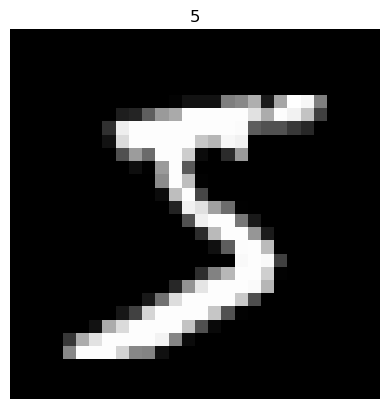

In [7]:
plt.title(labels_map[trainset[0][1]])
plt.axis("off")
plt.imshow(trainset[0][0][0, :, :], cmap = "gray")
    
plt.show()

In [18]:
len(trainset[1][0][0]), len(trainset[1][0][0][0])

(28, 28)

In [14]:
class NumberCNN(nn.Module):
    def __init__(self):
        # 데이터 크기 28 * 28
        super().__init__()
        # Sequential 은 forward 함수에서 구현될 순전파를 계층 형태로 더 가독성 있게 만들어줌
        # 즉, 계층을 차례대로 쌓을 수 있도록 Wx + b와 같은 수식과 활성화 함수를 연결해주는 역할
        # 데이터가 각 계층을 순차적으로 지나갈 때 효과적
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
            # (28 - 3 + 2 * 1)/1 + 1 = 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            # 28 / 2 = 14
        )
        self.fc1 = nn.Linear(in_features = 32 * 14 * 14, out_features = 50)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features = 50, out_features = 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

In [15]:
# 합성곱 신경망 파라미터 정의
learning_rate = 0.0001
model = NumberCNN() # 위에서 만든 class를 객체화
model.to(device)

criterion = nn.CrossEntropyLoss() # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # adam
print(model)

NumberCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6272, out_features=50, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [16]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        test = Variable(labels)
        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%")

Iteration: 500, Loss: 0.24813717603683472, Accuracy: 94.37000274658203%
Iteration: 1000, Loss: 0.17240934073925018, Accuracy: 95.88999938964844%
Iteration: 1500, Loss: 0.11079028993844986, Accuracy: 96.37000274658203%
Iteration: 2000, Loss: 0.07426141202449799, Accuracy: 96.88999938964844%
Iteration: 2500, Loss: 0.025752639397978783, Accuracy: 97.13999938964844%
Iteration: 3000, Loss: 0.15908658504486084, Accuracy: 97.36000061035156%
